# Bank's Credit Card Service Churn Prediction
In this project, I will build a <b>machine learning model to predict customer's probability of churning in a bank's credit card service.</b> It involves <b>supervised learning (using a labeled training set) for classification</b>, where the <b>target</b> is <b>1</b> if the <b>customer churned</b>, else <b>0.</b>

I will use the following <b>pipeline</b> based on <b>CRISP-DM framework:</b>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis)</b><br>
<b>5. Feature engineering, data cleaning and preprocessing.</b><br>
<b>6. Model training and comparison, feature selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>
<b>9. Deploy.</b><br>

In <b>this notebook</b>, I will perform <b>machine learning modelling, covering steps 5 to 8 of the pipeline above.</b> The main <b>objective</b> here is to <b>build a model that can accurately predict the probability of a customer churning.</b> Once I build this model, the <b>bank can plan strategies for client retention, maintaining healthy revenue. Acquiring new customers is costlier than keeping existing ones.</b> Furthermore, I will approach these steps in detail below, explaining why I am making each decision.

### Importing the libraries

In [1]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna
import shap
shap.initjs()

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from src.modelling_utils import *

### Visualization Settings
%matplotlib inline

#mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
#mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

/Users/pedrohenriquealmeidaoliveira/Documents/data_science/Churn-Prediction-Credit-Card/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

### Read the dataset

In [2]:
data_path = '../input/BankChurners.csv'
df = pd.read_csv(data_path)

In [85]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


- I will rename the columns in a standard format in order to turn the data manipulation easier. Attrition_flag will be renamed as churn_flag for interpretation purposes. Moreover, I will convert it to a binary format, in order to fit machine learning algorithms.

In [86]:
df.columns = [x.lower() for x in df.columns]

In [87]:
df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)
df['churn_flag'] = df['churn_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

### Split the data into train and test sets
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- A good practice to protect the model against data leakage is perform fit_transform on training data and just transform on test data when applying preprocessing steps after the split.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more existing customers than attrited ones.

In [88]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [89]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (8101, 22).
Train target dataset shape: (8101,).
Test predictor dataset shape: (2026, 22).
Test target dataset shape: (2026,).


In [90]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Test target proportion: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


The target classes proportions were preserved.

# 5. Feature engineering, data cleaning and preprocessing
In order to fit machine learning algorithms, it is necessary to apply some transformations to the data. There are no missing values in the data and the outliers don't represent inconsistent information. Thus, I will just need to apply preprocessing techniques, mentioned below.

Considering linear and tree-based models require distinct pre-processing techniques, I will build two preprocessors:
- For the tree-based models preprocessor, I will not apply any preprocessing technique to numerical features because these models don't require feature scaling. For the categorical features with ordinal relationships (education level, income category, and card category), I will apply ordinal encoding, in order to preserve this characteristic. For the remaining categorical feature (marital status), I will apply target encoding because one-hot encoding might be harmful for tree-based models due to the sparse representation and increased dimensionality. One-hot encoding will only be applied to gender, because it will be converted into a unique binary variable, not increasing dimensionality.
- For the linear models, I will apply standard scaling to numerical features because these algorithms utilize distance based calculations or optimization algorithms such as gradient descent, being sensitive to scale. For the categorical features, I will apply one-hot encoding. This is because linear models present the linearity assumption. Linear models take advantage from this encoding technique because, by creating dummies for each category, we treat them individually, assigning a distinct weight and making sure linearity is present - 1 when that category is present, else 0. An important observation is that, once I am focusing on predictive power, I will not spend much time searching for multicolinearity issues or discretizing numerical continuous variables (tasks for enhancing linear models performance, attending their assumptions) because my idea is to use a robust model such as LightGBM. I will test linear models just to see whether their performances beats this powerful gradient boosting algorithm. If that's the case, I would use them, balancing the computational cost.

Feature engineering:
- In order to extract the maximum information from the available features, I will do some feature engineering, which is already embedded in the preprocessor.
- I will create the following features:
    - Ratio features: products_per_dependent (total_relationship_count/dependent_count), trans_amt_per_dependent (total_trans_amt/dependent_count), trans_ct_per_dependent (total_trans_ct/dependent_count), trans_amt_per_products (total_trans_amt/total_relationship_count), trans_ct_per_products (total_trans_ct/total_relationship_count), avg_trans_amt (total_trans_amt/total_trans_ct), credit_util_rate (total_revolving_bal/credit_limit), proportion_inactive_months (months_inactive_12_mon/months_on_book), products_per_tenure (total_relationship_count/months_on_book), products_per_contacts (total_relationship_count/contacts_count_12_mon), dependents_per_contacts (dependent_count/contacts_count_12_mon), trans_ct_per_contacts (total_trans_ct/contacts_count_12_mon), products_per_inactivity (total_relationship_count/months_inactive_12_mon), dependents_per_inactivity (dependent_count/months_inactive_12_mon), trans_ct_per_inactivity (total_trans_ct/months_inactive_12_mon), trans_amt_per_credit_limit (total_trans_amt/credit_limit), age_per_tenure (customer_age/months_on_book), trans_ct_per_tenure (total_trans_ct/months_on_book), trans_amt_per_tenure (total_trans_amt/months_on_book).
    - Sum features: total_spending (total_trans_amt + total_revolving_bal), education_income_levels (education_level + income_category, ordinal), inactivity_contacts (contacts_count_12_mon + months_inactive_12_mon).
    - Considering these are numeric variables, all will be scaled to go for the stratified k-fold cross validation (models comparison) step.
    - Eventually, other features will be added. These features above can already capture hided relationships and patterns. Moreover, they make sense in the business context. This is something to take into account when performing feature engineering.
    
Considerations about some nuances seen in eda:
- I will leave the 'unknown' category in income_category, marital_status and education_level as another category of these variables. This is because I saw on eda that this category presents discrimination between churners and non-churners. Specifically, in marital_status, it presents the highest churn rate. For education_level and income_category, it presents the second highest churn rates. Thus, I will not do any imputation. Imputing would introduce bias and information loss.
- I will leave the card_category variable in the data because although it is highly imbalanced, it was observed that Gold and Silver category present some higher churn rates. Once I intend to build robust models such as LightGBM, focusing on predictive power, I will keep this variable and apply a feature selection method to remove it in case it is useless.
- I will drop avg_open_to_buy because I observed it is perfectly positively correlated with credit_limit, turning its information redundant.
- I will drop CLIENTNUM because it has a unique value for each record. 
- I will drop two specific variables because I don't have access to what they mean, and they seem to be results of a Naive Bayes machine learning model.
- Again, I will not treat issues like multicolinearity because the focus is on building robust models such as LightGBM, trying to reach the maximum predictive power.

All the preprocessing mentioned above is done by transformer classes, defined in "modelling_utils.py". This enable us to integrate everything in a unique sklearn pipeline, facilitating the model deployment in production environment.

In [92]:
X_train.head()

,clientnum,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
2856,787504158,36,F,0,Unknown,Married,Less than $40K,Blue,24,4,...,2570.0,2230,340.0,0.686,1755,42,0.448,0.868,0.000170,0.99983
6515,718279008,44,M,3,High School,Single,$60K - $80K,Silver,36,5,...,25276.0,0,25276.0,0.849,2282,38,0.583,0.000,0.994300,0.00570
7141,771338658,46,M,2,High School,Married,$80K - $120K,Blue,30,6,...,11670.0,915,10755.0,0.892,4277,89,0.854,0.078,0.000105,0.99989
632,714529233,36,F,2,Graduate,Married,Less than $40K,Blue,24,3,...,3124.0,1593,1531.0,0.869,1652,41,0.367,0.510,0.000093,0.99991
3496,717582558,50,M,1,Graduate,Single,$120K +,Blue,40,4,...,34516.0,1185,33331.0,0.725,3874,72,0.714,0.034,0.000180,0.99982


Check numerical features.

In [93]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features.')
print('They are:')
print(numerical_features)

There are 17 numerical features.
They are:
['clientnum', 'customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2']


Check categorical features cardinality and unique values.

In [94]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
print(f'There are {len(categorical_features)} categorical features.')
print('They are: ')
print(categorical_features)

There are 5 categorical features.
They are: 
['gender', 'education_level', 'marital_status', 'income_category', 'card_category']


In [95]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {X_train[feature].nunique()} unique values. They are: ')
    print(X_train[feature].value_counts(normalize=True))
    print()

gender
----------------------------------------
There are 2 unique values. They are: 
gender
F    0.527342
M    0.472658
Name: proportion, dtype: float64

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, 

I will build both the preprocessors below, following the techniques I have mentioned above.

In [96]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = ['gender', 
                             'education_level', 
                             'marital_status', 
                             'income_category', 
                             'card_category']
std_scaling_features = ['customer_age', 
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal', 
                        'avg_open_to_buy', 
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'trans_ct_per_dependent',
                        'trans_amt_per_products',
                        'trans_ct_per_products',
                        'avg_trans_amt',
                        'credit_util_rate',
                        'proportion_inactive_months',
                        'products_per_tenure',
                        'products_per_contacts',
                        'dependents_per_contacts',
                        'trans_ct_per_contacts',
                        'products_per_inactivity',
                        'dependents_per_inactivity',
                        'trans_ct_per_inactivity',
                        'trans_amt_per_credit_limit',
                        'age_per_tenure',
                        'trans_ct_per_tenure',
                        'trans_amt_per_tenure',
                        'total_spending',
                        'inactivity_contacts',
                        'education_income_levels']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

linear_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('std_scaler', StandardFeatureScaler(to_scale=std_scaling_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_train_prepared_linear.shape

(8101, 55)

In [97]:
X_train_prepared_linear.head()

,avg_utilization_ratio,gender_M,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,education_level_Unknown,marital_status_Married,marital_status_Single,...,products_per_inactivity,dependents_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels
0,0.868,0,0,0,0,0,0,1,1,0,...,-0.485952,-1.237821,-0.880000,-0.381331,0.816497,-0.178604,-0.494497,-0.442467,0.129437,-1.477093
1,0.000,1,0,0,1,0,0,0,0,1,...,0.365249,0.264667,-0.663276,-1.013049,-0.443162,-0.943028,-0.578903,-0.922191,0.129437,0.026353
2,0.078,1,0,0,1,0,0,0,1,0,...,0.000449,-0.570049,-0.200931,-0.718602,0.967656,1.160665,0.107518,-0.102463,-0.526738,0.527502
3,0.510,0,0,1,0,0,0,0,1,0,...,0.730050,0.765496,0.290311,-0.545573,0.816497,-0.224470,-0.531703,-0.650920,-0.526738,0.026353
4,0.034,1,0,1,0,0,0,0,0,1,...,0.000449,-0.736992,0.073587,-0.989645,-0.317196,-0.123566,-0.288816,-0.139928,0.129437,2.030949


In [98]:
# Construct the preprocessor for tree-based models.
one_hot_encoding_features = ['gender']

# I will encode 'unknown' as the last one, due to its churn rate (among the first or second highest one).
ordinal_encoding_orders = {
    'education_level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'income_category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'card_category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}

target_encoding_features = ['marital_status']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

tree_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
        ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_prepared_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_train_prepared_tree.shape

(8101, 40)

In [99]:
X_train_prepared_tree.head()

,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,...,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,inactivity_contacts,education_income_levels,gender_M,education_level,income_category,card_category,marital_status
0,36,0,24,4,3,2,2570.0,2230,0.686,1755,...,1.750000,73.125000,3985,5,0,0,6,0,0,0.153397
1,44,3,36,5,2,3,25276.0,0,0.849,2282,...,1.055556,63.388889,2282,5,3,1,1,2,1,0.168998
2,46,2,30,6,3,1,11670.0,915,0.892,4277,...,2.966667,142.566667,5192,4,4,1,1,3,0,0.153397
3,36,2,24,3,1,3,3124.0,1593,0.869,1652,...,1.708333,68.833333,3245,4,3,0,3,0,0,0.153397
4,50,1,40,4,2,3,34516.0,1185,0.725,3874,...,1.800000,96.850000,5059,5,7,1,3,4,0,0.168998


# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models performances. In order to achieve this, I will use stratified k-fold cross validation to train each one of them and evaluate their ROC-AUC score. Accuracy is not a good metric because the target is imbalanced. Moreover, stratified k-fold cross validation will maintain the target proportion on each fold, dealing with the imbalanced target as well.
- <b>K-fold cross-validation</b> is a technique used in machine learning to assess the performance of a model. It involves dividing the dataset into K subsets, using K-1 for training and one for testing iteratively. This helps in estimating a model's generalization ability by reducing the risk of overfitting and providing more reliable performance metrics.
- My objective here is to select a best model to go for feature selection, hyperparameter tuning and final model evaluation. In order to get this best model, I will evaluate the highest roc-auc average validation scores and look at the bias-variance trade-off.

In [139]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

Logistic Regression results: 
--------------------------------------------------
Training score: 0.8158226824266422
Average validation score: 0.9428151789084976
Standard deviation: 0.005228393787689332
Training time: 0.34987 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.813085540048471
Average validation score: 0.942399838686754
Standard deviation: 0.00503094920785542
Training time: 0.38952 seconds

KNN results: 
--------------------------------------------------
Training score: 0.8708612159238202
Average validation score: 0.9289137881952014
Standard deviation: 0.01102718807675875
Training time: 0.00673 seconds



,model,avg_val_score,train_score
0,Logistic Regression,0.942815,0.815823
1,Linear SVC,0.942400,0.813086
2,KNN,0.928914,0.870861


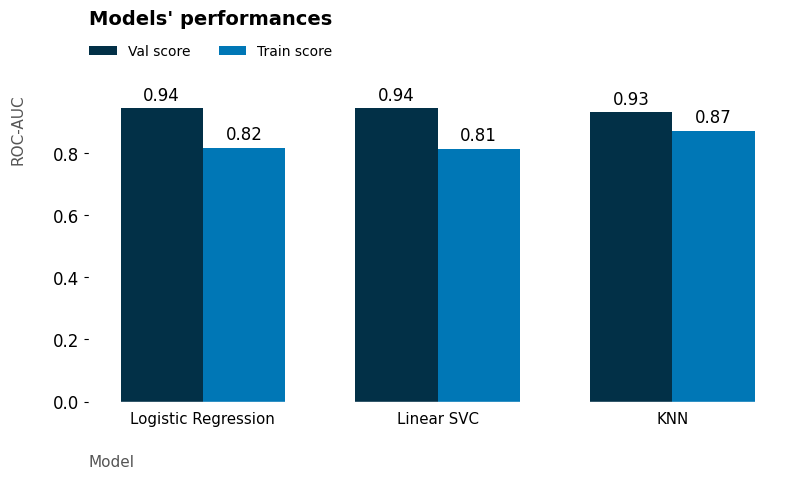

In [135]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_prepared_linear, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.8750743029629392
Standard deviation: 0.010183609213083089
Training time: 0.17754 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9871222037360873
Standard deviation: 0.003108812670774505
Training time: 1.33113 seconds

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5536
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
[LightGBM] [Info] N

,model,avg_val_score,train_score
0,LightGBM,0.992292,1.0
1,Random Forest,0.987122,1.0
2,Decision Tree,0.875074,1.0


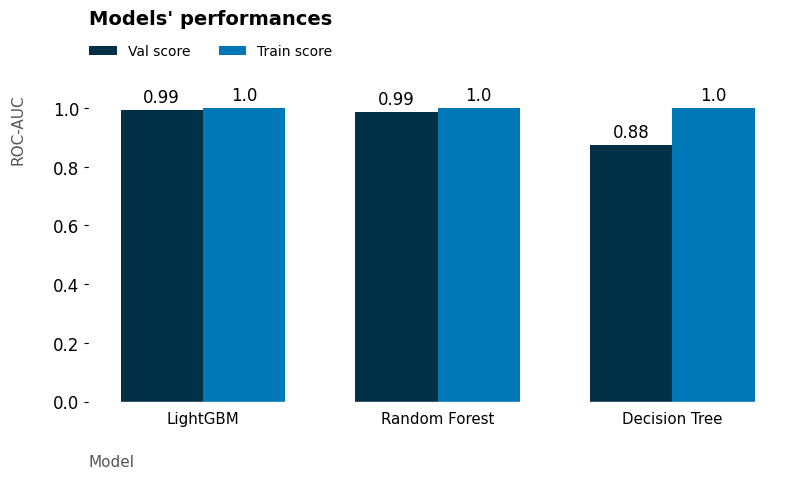

In [140]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_prepared_tree, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

The results are great. I will go with LightGBM for feature selection, hyperparameter tuning and final model evaluation because it presents the highest average validation ROC-AUC score. Although the model is overfitted, with a 1 ROC-AUC score on training data, its validation score is very close (0.99). This outstanding performance is not because data leakage, once all the features included are present at the moment of prediction and the split was made before everything. It is due to the quality of the data, the independent variables clearly separate churners and non-churners. Moreover, because of the result, hyperparameter tuning would not even add any performance. However, to demonstrate knowledge, I will apply it.

### Feature selection
- The feature selection step is crucial for improving the model's generalization ability and making it less complex, thus reducing computational costs. Given that we have 40 features, simplifying the model without losing performance is highly advantageous.
- I will use the Recursive Feature Elimination (RFE) method for feature selection.
- Recursive Feature Elimination (RFE) is a feature selection method that systematically removes irrelevant or less important features from a predictive model. It works by recursively training the model on subsets of features, ranking them based on their importance, and eliminating the least important features until the desired number of features is reached
- An important hyperparameter of RFE is the final desired number of features. In order to automatically select this value, I will use sklearn's RFECV class. It will apply stratified k-fold cross validation to find the best value for this hyperparameter. 

In [ ]:
# Recursively select the features with highest feature importances until the final desired number of features is obtained.
rfe = RecursiveFeatureEliminator(n_folds=5, 
                                 scoring='roc_auc',
                                 estimator=LGBMClassifier())
rfe.fit(X_train_prepared_tree, y_train)
X_train_selected = rfe.transform(X_train_prepared_tree)
X_train_selected.shape

In [166]:
# Visualize the final selected features.
X_train_selected.head()

,customer_age,contacts_count_12_mon,credit_limit,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,trans_amt_per_dependent,...,products_per_tenure,trans_ct_per_contacts,products_per_inactivity,trans_ct_per_inactivity,trans_amt_per_credit_limit,age_per_tenure,trans_ct_per_tenure,trans_amt_per_tenure,total_spending,education_income_levels
0,36.0,2.0,2570.0,2230.0,0.686,1755.0,42.0,0.448,0.868,0.000000,...,0.166667,21.000000,1.333333,14.000000,0.682879,1.500000,1.750000,73.125000,3985.0,0.0
1,44.0,3.0,25276.0,0.0,0.849,2282.0,38.0,0.583,0.000,760.666667,...,0.138889,12.666667,2.500000,19.000000,0.090283,1.222222,1.055556,63.388889,2282.0,3.0
2,46.0,1.0,11670.0,915.0,0.892,4277.0,89.0,0.854,0.078,2138.500000,...,0.200000,89.000000,2.000000,29.666667,0.366495,1.533333,2.966667,142.566667,5192.0,4.0
3,36.0,3.0,3124.0,1593.0,0.869,1652.0,41.0,0.367,0.510,826.000000,...,0.125000,13.666667,3.000000,41.000000,0.528809,1.500000,1.708333,68.833333,3245.0,3.0
4,50.0,3.0,34516.0,1185.0,0.725,3874.0,72.0,0.714,0.034,3874.000000,...,0.100000,24.000000,2.000000,36.000000,0.112238,1.250000,1.800000,96.850000,5059.0,7.0


In [167]:
X_train_selected.columns.tolist()

['customer_age',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'trans_amt_per_dependent',
 'trans_ct_per_dependent',
 'trans_amt_per_products',
 'trans_ct_per_products',
 'avg_trans_amt',
 'proportion_inactive_months',
 'products_per_tenure',
 'trans_ct_per_contacts',
 'products_per_inactivity',
 'trans_ct_per_inactivity',
 'trans_amt_per_credit_limit',
 'age_per_tenure',
 'trans_ct_per_tenure',
 'trans_amt_per_tenure',
 'total_spending',
 'education_income_levels']

- As we can see, features that showed a clear discrimination between churners and non-churners were maintained, such as total_trans_ct and total_trans_amt. Moreover, a lot of features created from the feature engineering were also maintained, demonstrating the importance of this task for model's performance.
- As a result, we went from 40 features to 25 final most important features, significantly reducing the computational complexity.

### Hyperparameter tuning
- I will tune the hyperparameters of LightGBM using Bayesian optimization through the optuna library.
- Bayesian optimization performs intelligent searches in the model's hyperparameter space, balancing the exploration-exploitation trade-off.
- Grid search is inefficient because it performs an exhaustive search, testing all possible parameter combinations and not considering parameter interaction effects. This would be detrimental in our case, as the training dataset is extensive, and parameters such as the number of trees and learning rate are related to others.
- In each iteration, we will train the model with the parameters on the training set and evaluate it with stratified k-fold cross validation to avoid overfitting resulting from excessive hyperparameter tuning on the training set.
- It is important to define the hyperparameter scale_pos_weight/class_weight to deal with imbalance. This hyperparameter will allow the model to better learn the patterns of the minority class (absent (1)) by giving greater weight to these instances. This weight will increase the cost of log-loss when misclassifying them, resulting in better learning in this class.
- Hyperparameter tuning represents a refinement. What considerably improves the model's performance is the feature engineering step.
- As I have mentioned before, given the outstanding performance of our model in this high quality data, hyperparameter tuning would not even be necessary. However, to demonstrate knowledge, I will perform it.
- The reference adopted for choosing the hyperparameters can be found at the following link. Normally, a higher number of trees and iterations would be defined. However, given my computer limitations, these parameters will be reduced. 
- https://www.linkedin.com/posts/pedro-almeida-ds_voc%C3%AA-fica-perdido-sobre-quais-combina%C3%A7%C3%B5es-activity-7168232226965385216-bvtw?utm_source=share&utm_medium=member_desktop

In [169]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    
    # Obtain average stratified k-fold cross validation roc-auc score.
    stratified_kfold = StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=42)
    val_scores = cross_val_score(model, 
                                 X_train_selected, 
                                 y_train, 
                                 scoring='roc_auc', 
                                 cv=stratified_kfold)
    avg_roc_auc = val_scores.mean()
    
    return avg_roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-03-23 20:39:37,567] A new study created in memory with name: no-name-77bfd888-eca0-4b7d-83c6-1a0904b228ce
[I 2024-03-23 20:40:11,150] Trial 0 finished with value: 0.9882844979234768 and parameters: {'learning_rate': 0.005570773367200067, 'num_leaves': 854, 'subsample': 0.6909316171337553, 'colsample_bytree': 0.12221218825068375, 'min_data_in_leaf': 36}. Best is trial 0 with value: 0.9882844979234768.
[I 2024-03-23 20:40:32,801] Trial 1 finished with value: 0.9925098048847204 and parameters: {'learning_rate': 0.058347642921077685, 'num_leaves': 529, 'subsample': 0.7719791569917934, 'colsample_bytree': 0.6743488670596399, 'min_data_in_leaf': 50}. Best is trial 1 with value: 0.9925098048847204.
[I 2024-03-23 20:40:57,799] Trial 2 finished with value: 0.9871836856727377 and parameters: {'learning_rate': 0.0020739060542539186, 'num_leaves': 278, 'subsample': 0.8958357005671851, 'colsample_bytree': 0.46940995771082494, 'min_data_in_leaf': 73}. Best is trial 1 with value: 0.9925098048

Best Hyperparameters: {'learning_rate': 0.017535345166904838, 'num_leaves': 942, 'subsample': 0.8490611533540497, 'colsample_bytree': 0.3775159533799494, 'min_data_in_leaf': 90}


### 7. Final production model testing and evaluation
- In this step, I intend to evaluate our final tuned model on test data (simulating production unseen data).
- Once I am facing a binary classification problem with an imbalanced target, it is important to look at metrics such as ROC-AUC. I want my model to discriminate well between churners and non-churners.
- Once the project objective is to order the customers by the churn probability, it is not necessary to calibrate the probabilities. The outputs of the model satisfy our goal.
- After evaluating the model, I will interpret its results.

Get the final tuned LightGBM model.

In [172]:
best_params = {'objective': 'binary',
               'metric': 'roc_auc',
               'n_estimators': 1000,
               'verbosity': -1,
               'bagging_freq': 1,
               'class_weight': 'balanced', 
               'learning_rate': 0.017535345166904838,
               'num_leaves': 942,
               'subsample': 0.8490611533540497,
               'colsample_bytree': 0.3775159533799494,
               'min_data_in_leaf': 90}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train_selected, y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.3775159533799494,
               learning_rate=0.017535345166904838, metric='roc_auc',
               min_data_in_leaf=90, n_estimators=1000, num_leaves=942,
               objective='binary', subsample=0.8490611533540497, verbosity=-1)

Use the preprocessor to transform the test predictor set. By applying just transform we avoid data leakage.

In [174]:
X_test_prepared = tree_preprocessor.transform(X_test)
X_test_selected = rfe.transform(X_test_prepared)
X_test_selected.shape

(2026, 25)

Predict.

In [176]:
y_pred = lgb_clf.predict(X_test_selected)

Get the model's estimated probabilities of churn.

In [177]:
churn_probas = lgb_clf.predict_proba(X_test_selected)[:, 1]

### Evaluate the final tuned LightGBM model.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.90      0.89      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.97      0.97      0.97      2026

Brier Score: 0.03
Gini: 0.98
KS: 0.9


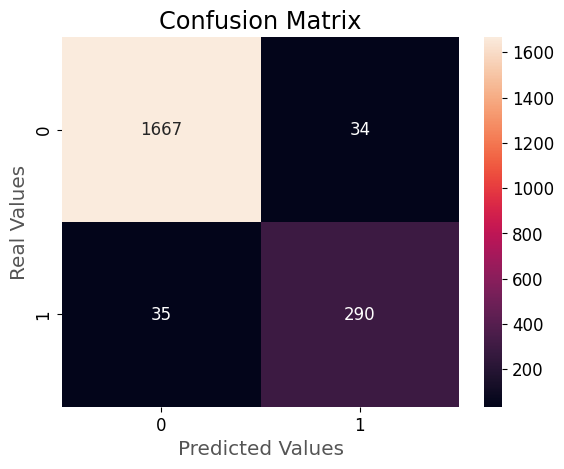

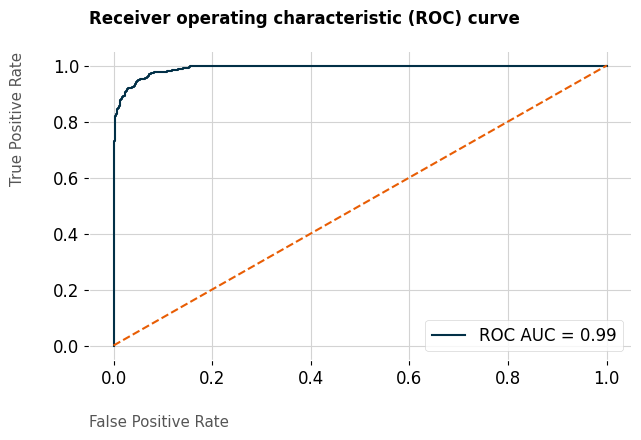

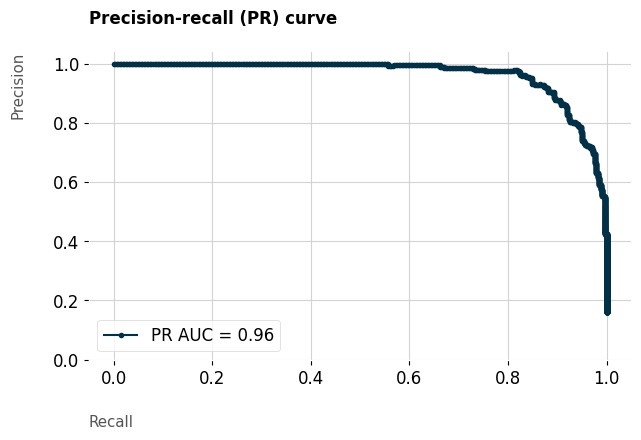

In [183]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)

In [184]:
model_metrics

,Metric,Value
0,Accuracy,0.965943
1,Precision,0.895062
2,Recall,0.892308
3,F1-Score,0.893683
4,ROC-AUC,0.991279
5,KS,0.898897
6,Gini,0.982559
7,PR-AUC,0.964932
8,Brier,0.025852


The model results are excellent!

<b>Recall (0.89):</b> The model correctly identifies 89% of the churners. In practical terms, looking at the confusion matrix, it has accurately predicted 290 out of 325 attrited customers.<br>
<b>Precision (0.90):</b> Out of all customers predicted as churn, 90% of them are actually churners. In practical terms, considering the confusion matrix, out of 324 customers predicted as churn, 290 of them are indeed churners.<br>
<b>ROC-AUC (0.99):</b> With a ROC-AUC score of 0.99, the model demonstrates outstanding ability to differentiate between attrited and existing customers. In practive, if we randomly choose a customer that churned and a customer that dind't churn, in 99% of the time the model will estimate a higher probability of churn for that customer who actually attrited.
- This outstanding performance is not because data leakage, once all the features included are present at the moment of prediction and the split was made before everything. It is due to the quality of the data, the independent variables clearly separate churners and non-churners.
- Finally, once the train, test and validation scores are similar, the model's generalization ability is reliable.

- Analyze the predicted probabilities distribution by churn.

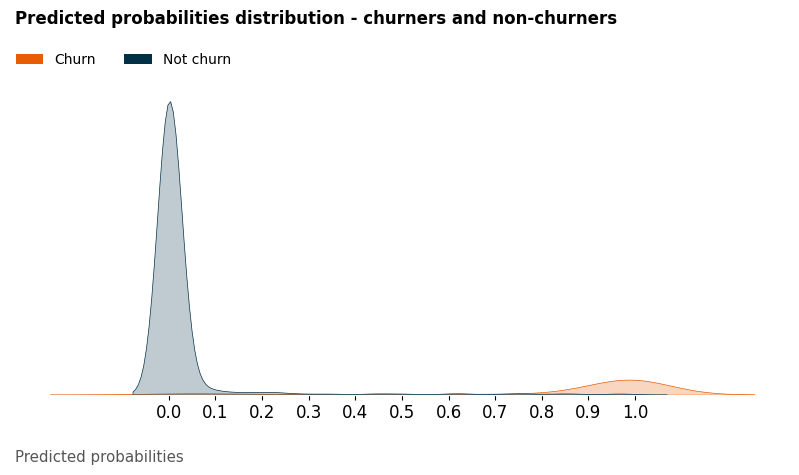

In [223]:
plot_probability_distributions(y_test, churn_probas)

- It is possible to see that there is a clear separation between the distributions of the predicted probabilities for churners and non-churners. Great!

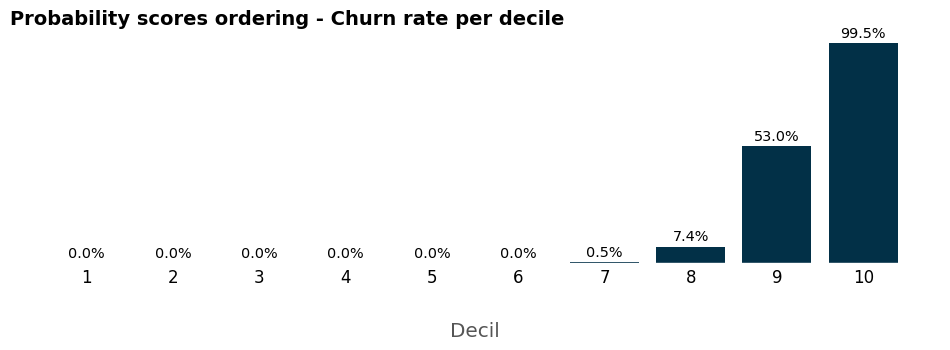

In [235]:
probability_scores_ordering(y_test, churn_probas)

- The probability scores ordering is also great. All the churners fall between the 7th and 10th deciles.

### Interpret the model results with SHAP values
- To interpret the results of LightGBM, I will analyze the SHAP values.
- SHAP is a library that allows the interpretation of machine learning algorithm results.
- With it, we can understand the impact of each feature on an individual model prediction. f(x) = E(f(x)) + SHAP.
- Basically, the SHAP value of a feature (how much it impacts an individual prediction) is the weighted sum of marginal contributions considering all possible feature coalitions. 
- A feature coalition is a group of features, and its value is the individual model prediction using only those features.
- The marginal contribution of a feature is the difference between the predicted value for a feature coalition with and without it.
- We sum the marginal contributions for all possible combinations with and without a feature.
- The weights are based on the probability of the feature we are calculating the SHAP value for being in that combination.

In [237]:
# Initialize the SHAP explainer with the final model.
explainer = shap.Explainer(lgb_clf)

# Compute shap values.
shap_values = explainer(X_test_selected)

In [238]:
# Assess the shape.
np.shape(shap_values.values)

(2026, 25)

In [243]:
# Assess some true labels.
y_test.reset_index(drop=True).sample(10, random_state=42)

1284    0
982     0
1542    1
593     0
1292    1
781     0
1576    0
367     0
1782    0
1788    0
Name: churn_flag, dtype: int64

- We have 25 variables. For each one, we have a corresponding SHAP value for every observation.
- For binary classification, we interpret the results in terms of log-odds. In the following plots, E(f(X)) represents the average prediction of log-odds. Log-odds is basically the logarithm of odds, the ratio between the probability of the event happening and the probability of the event not happening. Logarithm is used to convert odds to a linear scale. Positive SHAP values increase the log-odds and consequently the probability of churning, and vice versa.
- To obtain the probability of churning from the log-odds, simply pass through the logistic function, defined as $$ \text{sigmoid}(x) = \frac{1}{1 + e^{-\ln\left(\frac{p}{1-p}\right)}} $$
- Through the waterfall plot, we will visualize the contribution of each feature in the prediction for a positive (churner) and negative (non-churner) instance.


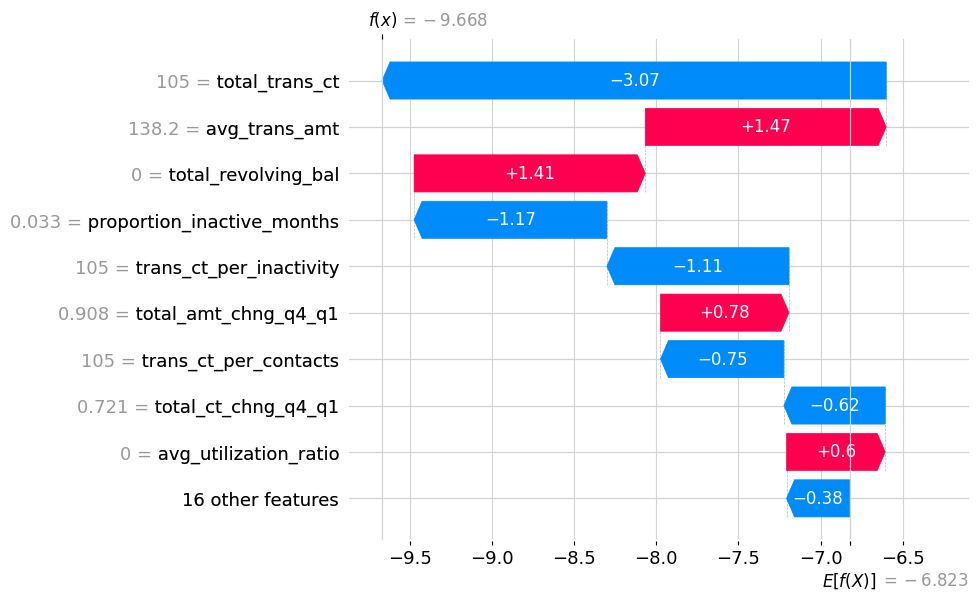

In [247]:
shap.plots.waterfall(shap_values[1])

- This customer did not churn. The estimated probability of churning for him through the logistic function is very close to zero,
- It is possible to see that the number of transactions made (in the last 12 months), which is equal to 105 in this case, reduced the log-odds of churning by 3.07. In contrast, the total revolving balance, which is zero, increased the log-odds of churning in 1.41. This makes total sense, since we saw that the higher the number of transactions the lower the churn risk, and a lot of churners were concentrated in null values of total revolving balance and average utilization ratio.
- Look how features we created in feature engineering impacted negatively or positively the log-odds of churning, in proportion_inactive_months and trans_ct_per_inactivity, for example.

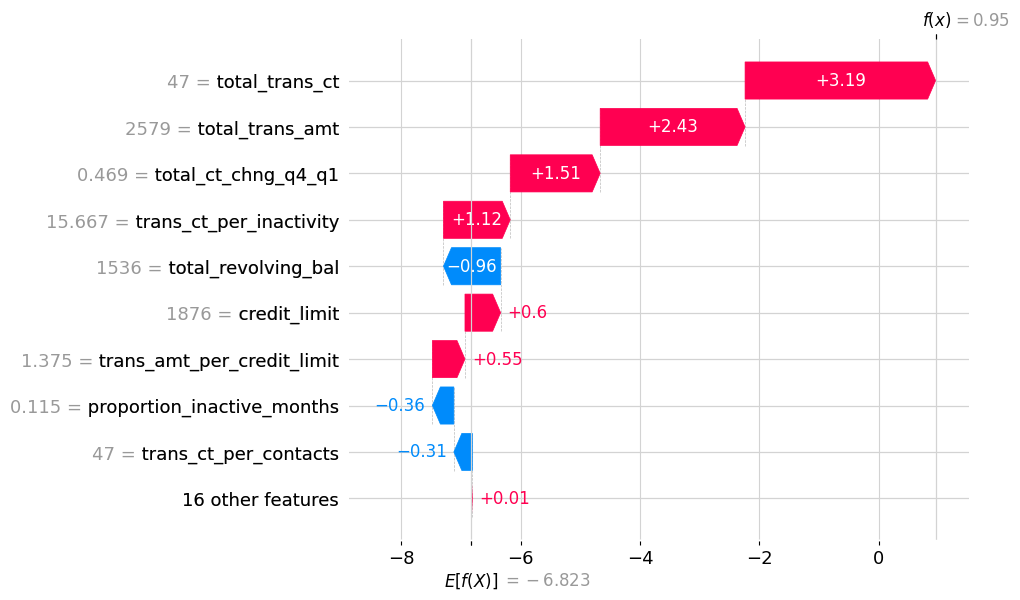

In [249]:
shap.plots.waterfall(shap_values[1542])

- This customer churned. The estimated probability of churning for him through the aforementioned logistic function is about 72%.
- It is possible to observe that, again, the number of transactions (in the last 12 months) increased the log-odds of churning by 3.19, which makes total sense, as mentioned before.

- Now, through the bar plot, we will observe which features are most important. In this plot, we have the average absolute SHAP value for each feature, indicating which features contribute more (positively or negatively) to the model predictions.

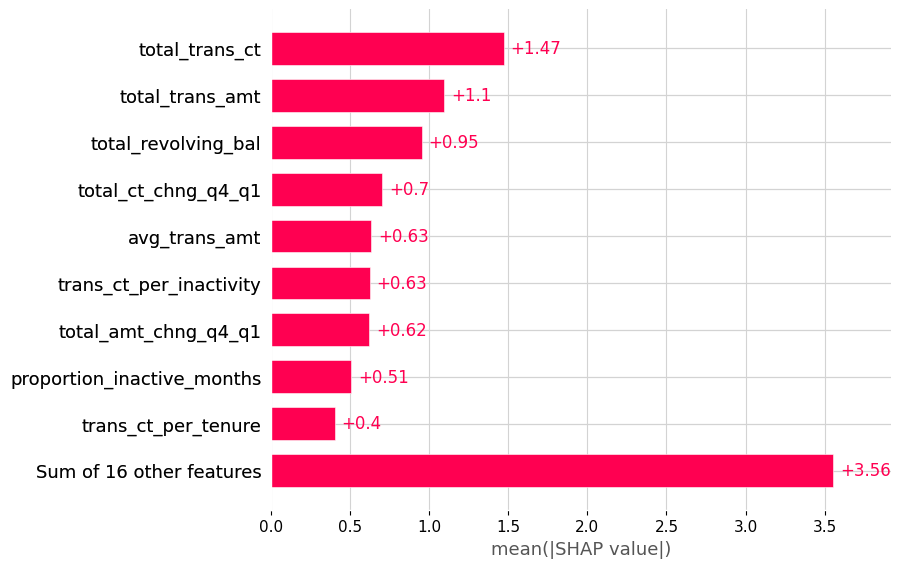

In [250]:
shap.plots.bar(shap_values)

- As expected, the number of transactions and the amount of transactions in the last 12 months are the most important features. It makes total sense, and we saw on eda that these variables presented a clear discrimination between churners and non-churners. Moreover, features we created on feature engineering step figured out as part of the most important ones, ilustrating the importance of this task in imporving a machine learning model's performance. It is the case for trans_ct_per_inactivity and avg_trans_amt, for example.

- Now, through the beeswarm plot, we can observe the relationship between the features and the model prediction.

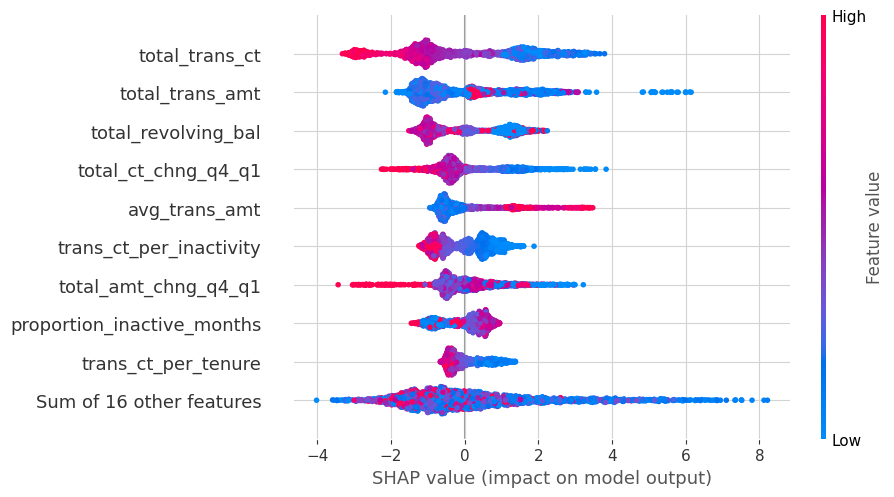

In [251]:
shap.plots.beeswarm(shap_values)

- It is noticeable that lower values of transaction counts in the last 12 months have a positive impact in the log-odds of churning, and, consequently, in the probability of churning, while higher values have a negative impact.
- Surprisingly, higher values of average transaction amount tend to reflect a positive impact in the log-odds of churning, and, consequently, in the probability of churning, while lower values tend to have a negative impact.

### Financial results
- I will express the model's performance in terms of financial results for the bank in order to show that the project is worth it. I will do this looking at the confusion matrix and our current data.
- I don't have access to specific data to obtain the exact financial gain. However, a common revenue source for credit card companies is charging fees on the outstanding balance, known as the total revolving balance, which cardholders carry from month to month. Thus, I will assume the bank's fee is 18% (a common value) and calculate the financial gain with it.
- Considering this, in order to estimate the financial gain provided by the model, I will take into account the following costs and benefits:
    1. Retention cost per client (false positive):
        - This cost applies to customers who wouldn't churn but were misclassified as churners by the model, leading the bank to incur expenses in retaining them. Specifically, to retain the customer, I will offer a discount on the fee, reducing it from 18% to 10%, resulting in a loss of revenue due to this 8% discount. 
    2. Revenue loss per churner (false negative):
        - This cost arises when customers who are actually going to churn are not correctly identified by the model, leading to the bank losing both these clients and the associated revenue. This cost will encompass the entire fee (18%) applied to the outstanding balances.
    3. Financial gain with the retention of a customer correctly predicted as a churner (true positive):
        - This gain occurs when the model accurately predicts a churner, enabling us to retain them along with the revenue they generate, applying the 10% fee on total revolving balances as our retention strategy.

Get a dataset for financial results.

In [253]:
financial_results = pd.concat([X_test, y_test], axis=1)[['total_revolving_bal', 'churn_flag']]
financial_results['predicted'] = y_pred

Get separate datasets for false positives, false negatives and true positives costs and gain estimation.

In [254]:
fp_data = financial_results.loc[(financial_results['churn_flag'] == 0) & (financial_results['predicted'] == 1)]
fn_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 0)]
tp_data = financial_results.loc[(financial_results['churn_flag'] == 1) & (financial_results['predicted'] == 1)]

Estimate the costs and gain.

In [255]:
fp_data['fp_cost'] = fp_data['total_revolving_bal']*1.18 - fp_data['total_revolving_bal']*1.10
fn_data['fn_cost'] = fn_data['total_revolving_bal']*1.18
tp_data['tp_gain'] = tp_data['total_revolving_bal']*1.10

Finally, the financial result given by the model will be the difference between the gain and the costs.

In [257]:
financial_gain = tp_data['tp_gain'].sum() - fp_data['fp_cost'].sum() - fn_data['total_revolving_bal'].sum()
print(f'The model provides a financial gain of: ${financial_gain:.1f}')

The model provides a financial gain of: $171477.2


Wow! Our model yields an estimated financial result of approximately $171,477. The actual amount will depend on the bank's management when implementing retention strategies for customers based on the predicted churn probabilities. For example, if the bank wishes to be more conservative, reducing expenses associated with false positives, it can target customers with higher churn probabilities, thereby altering the potential gain. Nevertheless, for estimation and foundational purposes, we have confirmed that the project is worthwhile.

# 8. Conclusions
- In this project, I have built a LightGBM classifier for predicting customer's probability of churning in a bank's credit card service. The objective of the project was to build a model that was able to accurately predict the probability of a customer to churn, uncover the churn factors within the available features and offer action plans to minimize the problem. By doing this, the company can plan strategies for retention, maintaining healthy revenue. Acquiring new customers is costlier than keeping existing ones.
- The business problem is solved now. My model is able to correctly predict 89% of the churners, with an AUC of 0.99 and an outstanding ability to discriminate between churners and non-churners! It indicates that, if we randomly choose a churner and a non-churner, in 99% of the time, the model will estimate a higher probability of churning for the customer who actually attrited. Furthermore, it was possible to uncover the main churn factors during the EDA step and provide some suggestions for the bank regard to attrition patterns.
- In order to deal with the imbalanced target, the strategies used were: Stratified hold-out and k-fold cross validation, and class_weight hyperparameter. I did not inted to use SMOTE because in real life it doesn't work. My goal here is to simulate a real data science case and solution. 
- The model results were interpreted and they are coherent! By looking at shap, it was possible to assess the features with the highest predictive power for the analysis and how they impact the model's outcome for single and all observations. In the EDA step, I had already thought these features would be the most useful, reinforcing that the estimator outcomes make sense. Finally, the model's estimated probabilities also make sense and thus everything is working fine.
- The project is worthwile. It provides a base estimated financial result of approximately $171,477. The concrete result will depend on the fees charged by the bank and its management when implementing retention strategies for customers based on the predicted churn probabilities. However, for estimation and foundational purposes, we have confirmed that it is worth it.
- The next step is to deploy the model using CI/CD pipeline principles, with modular coding.